# 导入必要包

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import  Dataset,random_split,DataLoader

# 定义绘图函数

In [76]:
# 定义一个函数，用于绘制时间序列
def plot_series(time, plot_series, format='-', start=0, end=None, label=None):
    """
    绘制时间序列的函数。

    参数:
    time (numpy.ndarray): 时间序列的时间点。
    plot_series (numpy.ndarray): 需要绘制的时间序列数据。
    format (str): 绘制格式，比如线条的样式。
    start (int): 绘制起始点，用于确定绘制的时间序列的起始位置。
    end (int): 绘制终止点，用于确定绘制的时间序列的终止位置。
    label (str): 标签名称，用于图例展示。

    返回:
    None
    """
    # 使用matplotlib绘制时间序列
    plt.plot(time[start:end], plot_series[start:end], format, label=label)
    plt.xlabel("Time")  # 设置x轴标签
    plt.ylabel("Value")  # 设置y轴标签
    if label:
        plt.legend(fontsize=14)  # 如果有标签，则添加图例
    plt.grid(True)  # 显示网格
    plt.show()  # 展示图像


# 数据生成函数的编写

In [77]:
# 定义趋势函数
def trend(time, slope=0):
    """
    生成趋势函数的方法。

    参数:
    time (numpy.ndarray): 时间点序列。
    slope (float): 斜率。

    返回:
    numpy.ndarray: 按照给定斜率生成的趋势函数值序列。
    """
    return (slope * time)

# 定义白噪声生成函数
def white_noise(time, std=1.0, seed=None):
    """
    生成白噪声的方法。

    参数:
    time (numpy.ndarray): 时间点序列。
    std (float): 标准差。
    seed (int): 随机种子。

    返回:
    numpy.ndarray: 生成的白噪声序列。
    """
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * std

# 定义季节性模式
def seasonal_pattern(season_time):
    """
    生成季节性模式的方法。

    参数:
    season_time (numpy.ndarray): 季节时间点序列。

    返回:
    numpy.ndarray: 生成的季节性模式序列。
    """
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

# 定义季节性函数
def seasonality(time, period, amplitude=1, phase=0):
    """
    生成季节性函数的方法。

    参数:
    time (numpy.ndarray): 时间点序列。
    period (int): 周期。
    amplitude (float): 振幅。
    phase (float): 相位。

    返回:
    numpy.ndarray: 生成的季节性函数值序列。
    """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


# 数据集的生成
## 数据集的划分于batch的生成

In [78]:
# 定义训练集与测试集划分函数
def train_test_split(series, split_fraction=0.7):
    """
    将数据集划分为训练集和测试集的方法。

    参数:
    series (list): 待划分的数据集。
    split_fraction (float): 划分比例。

    返回:
    tuple: 划分后的训练集和测试集。
    """

    # 计算训练集大小
    train_size = int(len(series) * split_fraction)
    # 划分训练集和测试集
    train_set = series[:train_size]
    test_set = series[train_size:]
    return train_set, test_set

# 定义数据集划分函数
def data_iter(batch_size, features, labels):
    """
    将数据集划分为指定大小的批次的方法。

    参数:
    batch_size (int): 批次大小。
    features (list): 特征数据。
    labels (list): 标签数据。

    返回:
    generator: 生成器，用于按批次迭代数据集。
    """

    # 获取样本数量
    num_examples = len(features)
    # 创建索引列表
    indices = list(range(num_examples))

    # 按批次迭代数据集
    for i in range(0, num_examples, batch_size):
        # 最后一次可能不满足一个batch
        j = torch.LongTensor(indices[i:min(i + batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)


## 滑动窗口的实现

In [79]:
def data_process(train, test, window_size):
    """
    数据预处理函数，用于将数据集处理成适合训练和测试的形式。

    参数:
    train (list): 训练集数据。
    test (list): 测试集数据。
    window_size (int): 窗口大小。

    返回:
    train_feature (Tensor): 训练集特征数据。
    train_label (Tensor): 训练集标签数据。
    test_feature (Tensor): 测试集特征数据。
    test_label (Tensor): 测试集标签数据。
    """
    train_tensor = torch.from_numpy(train)  # 将训练集转换为张量
    train_windows_split = train_tensor.unfold(0, window_size, 1)  # 划分训练集窗口
    train_set = train_windows_split.numpy()  # 转换为 NumPy 数组

    test_tensor = torch.from_numpy(test)  # 将测试集转换为张量
    test_windows_split = test_tensor.unfold(0, window_size, 1)  # 划分测试集窗口
    test_set = test_windows_split.numpy()  # 转换为 NumPy 数组

    # 将训练集短序列打乱
    train_temp1 = train_set.tolist()
    random.shuffle(train_temp1)
    train_temp2 = np.array(train_temp1)

    test_temp1 = test_set.tolist()
    # random.shuffle(test_temp1)
    test_temp2 = np.array(test_temp1)

    # 将短序列划分为 feature 和 label
    train_feature_array = train_temp2[:, :window_size - 1]
    train_label_array = train_temp2[:, window_size - 1:]

    test_feature_array = test_temp2[:, :window_size - 1]
    test_label_array = test_temp2[:, window_size - 1:]

    # 将 np.array 转为 tensor
    train_feature_tensor = torch.from_numpy(train_feature_array)
    train_label = torch.from_numpy(train_label_array)
    test_feature_tensor = torch.from_numpy(test_feature_array)
    test_label = torch.from_numpy(test_label_array)

    # 扩展数据维度，符合 CNN 输入
    train_feature = train_feature_tensor.reshape(train_feature_tensor.shape[0], 1, train_feature_tensor.shape[1])
    test_feature = test_feature_tensor.reshape(test_feature_tensor.shape[0], 1, test_feature_tensor.shape[1])

    return train_feature, train_label, test_feature, test_label


# 生成虚拟数据集

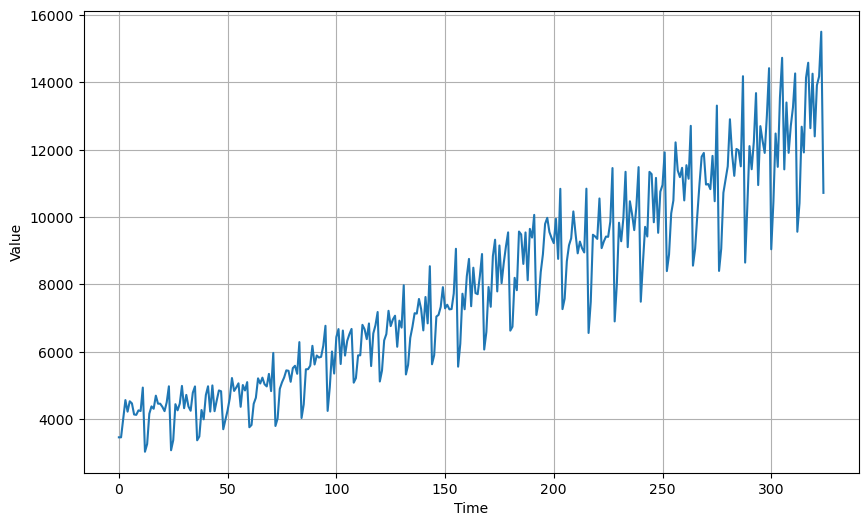

In [80]:
# 从CSV文件读取数据
data = pd.read_csv(r'E:\PythonCode\DeepLearning\Time_Series\data\experment_03\alcohol.csv')

# 提取数据列
series =  data['S4248SM144NCEN'].values

# 创建时间序列
time = np.arange(len(series))

# 将数据类型转换为 double
series.astype(np.double)

# 绘制时间序列图
plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()


# 数据处理

In [81]:
import torch
from torch.utils.data import Dataset, DataLoader

# 划分训练集和测试集
split_prop = 0.7
train, test = train_test_split(series, split_prop)
windows_size = 6

# 调用data_process进行数据处理
train_feature, train_label, test_feature, test_label = data_process(train, test, windows_size)

# 分别输出训练集和测试集的 feature 和 label
batch_size = 128


# 定义神经网络

In [82]:
# 创建一个继承自nn.Module的ConvModel类
class ConvModel(nn.Module):
    # 定义初始化函数
    def __init__(self):
        # 调用父类的初始化函数
        super(ConvModel, self).__init__()
        # 定义第一个卷积层
        self.conv1 = nn.Sequential(
            # 定义1维卷积层
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            # 定义激活函数ReLU
            nn.ReLU(inplace=True)
        )
        # 定义第二个卷积层
        self.conv2 = nn.Sequential(
            # 定义1维卷积层
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2, stride=1, padding=1),
            # 定义激活函数ReLU
            nn.ReLU(inplace=True)
        )
        # 定义全连接层1
        self.fc1 = nn.Linear(64, 128)
        # 定义全连接层2
        self.fc2 = nn.Linear(128, 1)

    # 定义前向传播函数
    def forward(self, x):
        # 进行第一次卷积操作
        out = self.conv1(x)
        # 进行第一次平均池化操作
        out = F.avg_pool1d(out, 2)  # 平均池化
        # 进行第二次卷积操作
        out = self.conv2(out)
        # 进行第二次平均池化操作
        out = F.avg_pool1d(out, 2)  # 平均池化层
        # 压缩维度
        out = out.squeeze()
        # 经过第一个全连接层
        out = self.fc1(out)
        # 经过第二个全连接层
        out = self.fc2(out)
        # 返回输出结果
        return out


In [83]:
# 设置学习率和迭代次数
lr = 0.01
epoch = 1000

# 创建模型实例并定义优化器
net = ConvModel()
opt = torch.optim.Adam(net.parameters(), lr=lr)

# 对模型参数进行初始化
for param in net.parameters():
    torch.nn.init.normal_(param, mean=0, std=0.01)

# 定义损失函数
def loss(x, y):
    return (net(x) - y) ** 2 / 2

# 初始化训练集和测试集的损失列表
train_loss = []
test_loss = []

# 检测是否有可用的GPU，将模型移至GPU设备上
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# 开始迭代训练
for epoch_num in range(epoch):
    train_list = []
    test_list = []
    for x, y in data_iter(batch_size, train_feature, train_label):
        x = x.to(torch.float32).to(device)
        y = y.to(torch.float32).to(device)
        l = loss(x, y).mean()
        if opt is not None:
            opt.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward()
        opt.step()
        train_list.append(l.item())
    for x, y in data_iter(batch_size, test_feature, test_label):
        x = x.to(torch.float32).to(device)
        y = y.to(torch.float32).to(device)
        l = loss(x, y).mean()
        test_list.append(l.item())
    test_loss.append(np.mean(test_list))
    train_loss.append(np.mean(train_list))
    print("epoch:", epoch_num + 1,
          "train_loss:", np.mean(test_list),
          "test_loss:", np.mean(train_list))


epoch: 1 train_loss: 64104868.0 test_loss: 22643188.0
epoch: 2 train_loss: 44238516.0 test_loss: 20894392.0
epoch: 3 train_loss: 1562860.375 test_loss: 11321227.25
epoch: 4 train_loss: 16061746.0 test_loss: 5649025.53125
epoch: 5 train_loss: 4518621.0 test_loss: 3200851.671875
epoch: 6 train_loss: 15433044.0 test_loss: 2667449.875
epoch: 7 train_loss: 13255709.0 test_loss: 5328240.75
epoch: 8 train_loss: 3255395.75 test_loss: 3667712.625
epoch: 9 train_loss: 5095389.0 test_loss: 705496.546875
epoch: 10 train_loss: 6855769.5 test_loss: 2270913.9375
epoch: 11 train_loss: 1389231.125 test_loss: 1621613.46875
epoch: 12 train_loss: 5016367.5 test_loss: 770319.28125
epoch: 13 train_loss: 4165232.75 test_loss: 1740712.75
epoch: 14 train_loss: 1319323.875 test_loss: 1071929.625
epoch: 15 train_loss: 3244428.5 test_loss: 467698.171875
epoch: 16 train_loss: 2308207.25 test_loss: 1080604.5625
epoch: 17 train_loss: 1473271.0 test_loss: 620702.625
epoch: 18 train_loss: 2518658.0 test_loss: 591356.4

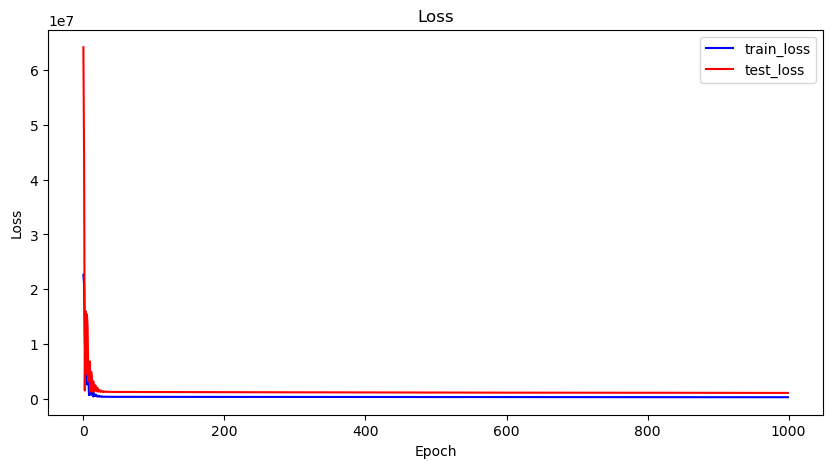

In [84]:
# 导入 matplotlib 库
from matplotlib import pyplot as plt

# 定义绘制损失函数曲线的函数
def plot_loss(train_loss, test_loss):
    """
    绘制损失函数曲线。

    参数:
    train_loss (list): 训练集损失值列表。
    test_loss (list): 测试集损失值列表。
    """
    # 设置绘图区域的大小
    plt.figure(figsize=(10, 5))
    # 绘制训练集损失曲线
    plt.plot(range(len(train_loss)), train_loss, 'b-', label="train_loss")
    # 绘制测试集损失曲线
    plt.plot(range(len(train_loss)), test_loss, 'r-', label="test_loss")
    plt.xlabel('Epoch')  # 设置横坐标标签
    plt.ylabel('Loss')  # 设置纵坐标标签
    plt.title('Loss')  # 设置图表标题
    plt.legend()  # 添加图例
    plt.show()  # 展示图表

# 调用绘制损失函数曲线的函数
plot_loss(train_loss, test_loss)


# 模型预测

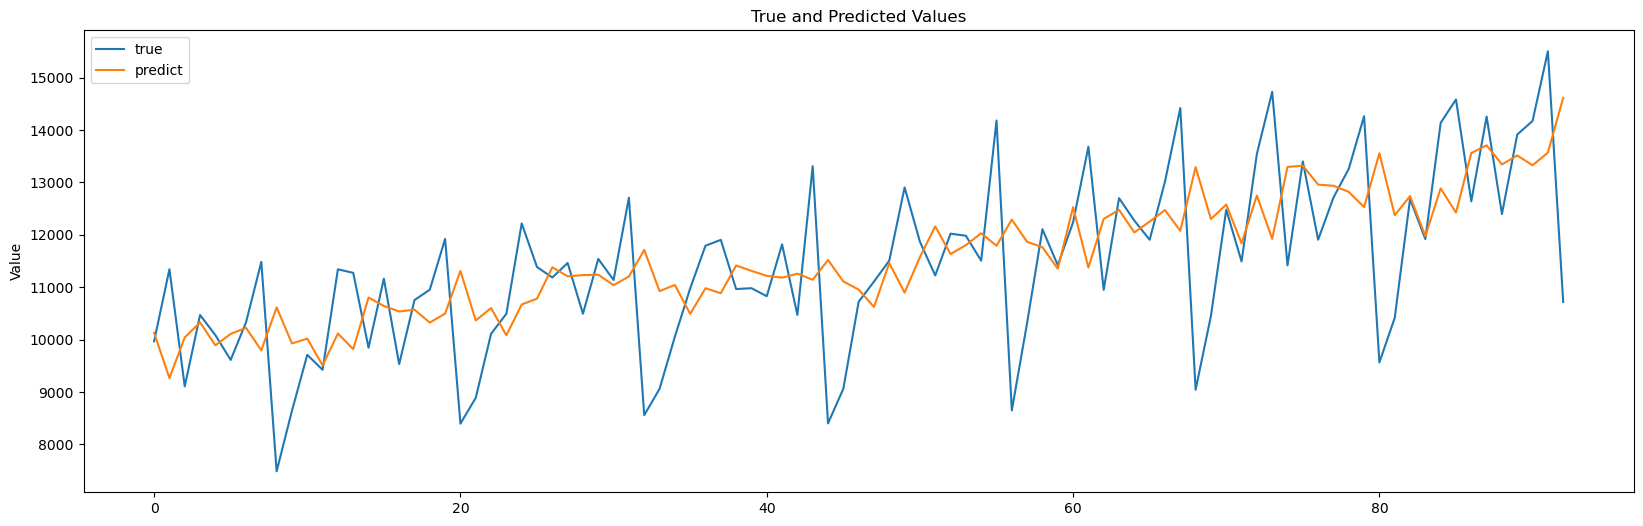

In [85]:
def plot_predictions(net, test_feature, test_label, split_prop, series):
    """
    绘制预测结果和真实结果的图表。

    参数:
    net (ConvModel): 训练好的模型。
    test_feature (Tensor): 测试集特征数据。
    test_label (Tensor): 测试集标签数据。
    split_prop (float): 分割比例。
    series (list): 数据集。

    """
    # 使用训练好的模型进行预测
    test_predict = net(test_feature.to(torch.float32).to(device)).squeeze().tolist()
    split_point = int(split_prop * int(series.size))
    test_true = test_label

    # 绘制真实值和预测值的对比图表
    plt.figure(figsize=(20, 6))
    plt.plot(test_true, label='true')  # 绘制真实值曲线
    plt.plot(test_predict, label='predict')  # 绘制预测值曲线
    plt.ylabel('Value')  # 设置纵坐标标签
    plt.title('True and Predicted Values')  # 设置图表标题
    plt.legend()  # 添加图例
    plt.show()  # 展示图表

# 调用绘制预测结果和真实结果图表的函数
plot_predictions(net, test_feature, test_label, split_prop, series)


# ResNet实现

In [86]:
import torch.nn as nn
import torchvision.models as models

class ResNet1D(nn.Module):
    def __init__(self, num_classes=32):
        super(ResNet1D, self).__init__()
        
        # 实例化一个ResNet模型，权重为None表示使用随机初始化的权重
        self.resnet = models.resnet18(weights=None)
        
        # 修改ResNet的第一层卷积层，将输入通道数由1变为64，卷积核的大小为(7, 1)，步长为(2, 1)，填充为(3, 0)，不使用偏置
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0), bias=False)
        
        # 修改ResNet的全连接层，将输出类别数改为num_classes
        self.resnet.fc = nn.Linear(512, num_classes)
        
        # 添加一个线性层，将输出类别数改为1
        self.fc = nn.Linear(num_classes, 1)
    
    def forward(self, x):
        # 增加一个维度，使得输入的张量变为四维张量
        x = x.unsqueeze(3)
        
        # 通过修改后的ResNet模型进行前向传播
        x = self.resnet(x)
        
        # 经过一个线性层
        x  = self.fc(x)
        
        return x


In [87]:
resNet = ResNet1D()  # 初始化 ResNet1D 模型
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # 指定设备为 GPU 或 CPU
resNet.to(device)  # 将模型移至指定设备
lr = 0.01  # 学习率
epoch = 1000  # 训练轮数

best_loss = float('inf')  # 初始化最佳损失为无穷大
best_model = None  # 初始化最佳模型为空
opt = torch.optim.Adam(resNet.parameters(), lr=lr)  # 定义优化器

def loss(x, y):
    return (resNet(x) - y) ** 2 / 2  # 定义损失函数

train_loss = []  # 用于保存训练集损失
test_loss = []  # 用于保存验证集损失
no_improvement_count = 0  # 连续多少个 epoch 验证集损失没有下降

for epoch_num in range(epoch):  # 开始迭代训练
    train_list = []  # 用于保存当前训练集损失
    test_list = []  # 用于保存当前验证集损失
    for x, y in data_iter(batch_size, train_feature, train_label):  # 遍历训练数据集
        x = x.to(torch.float32).to(device)  # 转换输入数据类型并移至指定设备
        y = y.to(torch.float32).to(device)  # 转换标签数据类型并移至指定设备
        l = loss(x, y).mean()  # 计算损失
        if opt is not None:
            opt.zero_grad()  # 梯度清零
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()  # 梯度清零
        l.backward()  # 反向传播
        opt.step()  # 更新参数
        train_list.append(l.item())  # 将当前批次训练集损失保存
    for x, y in data_iter(batch_size, test_feature, test_label):  # 遍历验证数据集
        x = x.to(torch.float32).to(device)  # 转换输入数据类型并移至指定设备
        y = y.to(torch.float32).to(device)  # 转换标签数据类型并移至指定设备
        l = loss(x, y).mean()  # 计算损失
        test_list.append(l.item())  # 将当前批次验证集损失保存
    test_loss.append(np.mean(test_list))  # 计算并保存当前验证集平均损失
    train_loss.append(np.mean(train_list))  # 计算并保存当前训练集平均损失
    print("epoch:", epoch_num + 1, "train_loss:", np.mean(test_list), "test_loss:", np.mean(train_list))  # 打印当前 epoch 的损失信息


epoch: 1 train_loss: 66091724.0 test_loss: 22657113.0
epoch: 2 train_loss: 65360588.0 test_loss: 22361377.0
epoch: 3 train_loss: 64263640.0 test_loss: 21833310.0
epoch: 4 train_loss: 62973556.0 test_loss: 21156049.0
epoch: 5 train_loss: 61327784.0 test_loss: 20311018.0
epoch: 6 train_loss: 59314824.0 test_loss: 19279039.0
epoch: 7 train_loss: 56994132.0 test_loss: 18007655.0
epoch: 8 train_loss: 54042336.0 test_loss: 16543580.5
epoch: 9 train_loss: 50980424.0 test_loss: 14820226.5
epoch: 10 train_loss: 48267792.0 test_loss: 12979552.0
epoch: 11 train_loss: 43524796.0 test_loss: 11247711.5
epoch: 12 train_loss: 37905084.0 test_loss: 8884302.0
epoch: 13 train_loss: 32906546.0 test_loss: 6673087.25
epoch: 14 train_loss: 28667914.0 test_loss: 4732024.625
epoch: 15 train_loss: 23325102.0 test_loss: 3032641.125
epoch: 16 train_loss: 18603752.0 test_loss: 1603717.125
epoch: 17 train_loss: 14408528.0 test_loss: 659926.046875
epoch: 18 train_loss: 11485158.0 test_loss: 381769.9375
epoch: 19 tra

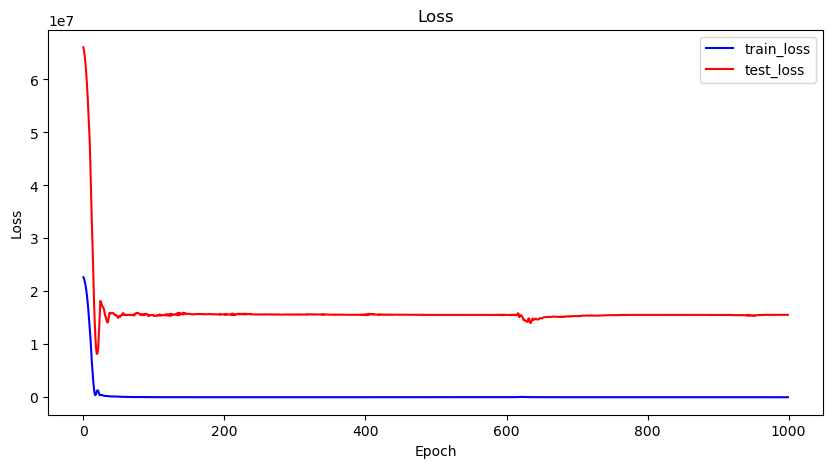

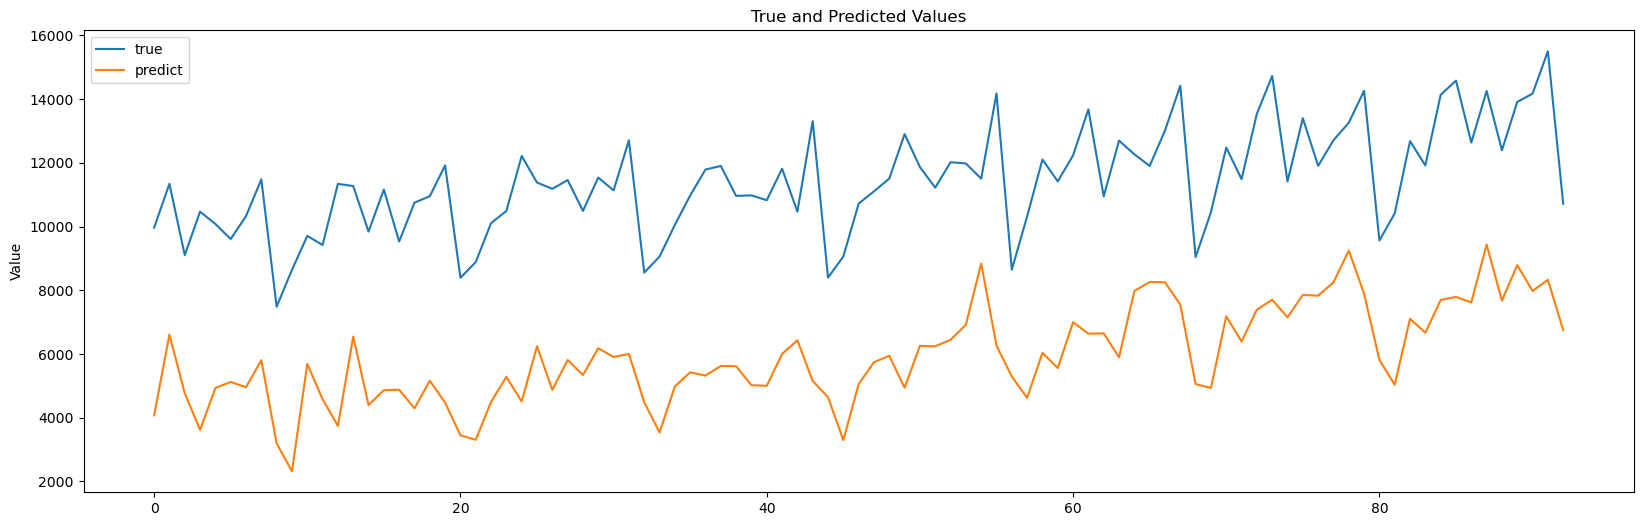

In [88]:
plot_loss(train_loss, test_loss)  # 绘制训练集和验证集损失曲线
plot_predictions(resNet, test_feature, test_label, split_prop, series)  # 绘制预测结果与真实结果对比图


# 实验总结与思考题
通过对比试验，可以看到换用ResNet网络后模型性能显著降低，通过调整实验参数，预测效果依旧不能获得显著提升。
## 思考题
问题1：为什么CNN的拟合效果反倒不好？
- 数据不足：如果数据量不够大，CNN 可能无法捕捉到时间序列的复杂模式。
- 模型复杂性：CNN 本身可能太过复杂，而时间序列数据并不足以支撑其复杂性。
- 特征提取不足：CNN 可能无法捕捉到时间序列中的长期依赖性，特别是对于具有长期依赖性的时间序列数据。
问题2：如何提高CNN的拟合效果？
- 数据增强：使用数据增强技术可以增加数据量，有助于改善 CNN 的拟合效果。
- 适当的超参数调整：调整 CNN 的超参数，如卷积核大小、步长、填充等，以更好地适应时间序列的特点。
- 增加层数或改变网络架构：可以尝试增加网络层数或尝试不同的 CNN 架构，以更好地捕捉时间序列中的模式。
问题3：CNN模型的优势体现在哪里？
- 局部模式识别：CNN 适用于识别时间序列中的局部模式和特征，例如某些特定的季节性变化。
- 参数共享：CNN 具有参数共享的特点，能够有效地减少模型参数数量，使得模型更具有泛化能力。
- 平移不变性：对于滑动窗口数据，CNN 可以捕捉到数据的平移不变性，这在某些情况下可能是非常有用的。